In [56]:
import yfinance as yf
import pandas as pd

In [57]:
# === CONFIG ===
TICKER = "GOOGL"          
BENCHMARK = "^GSPC"       
START_DATE = "2016-02-01" 
END_DATE = "2020-07-30"   

# === FETCH DATA ===
goog = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", progress=False)
sp500 = yf.download(BENCHMARK, start=START_DATE, end=END_DATE, interval="1d", progress=False)

# === CLEAN COLUMN NAMES ===
goog = goog.rename(columns=lambda x: f"{TICKER}_{x}")
sp500 = sp500.rename(columns=lambda x: f"SP500_{x}")

/tmp/ipykernel_36/3887304188.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  goog = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", progress=False)
/tmp/ipykernel_36/3887304188.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(BENCHMARK, start=START_DATE, end=END_DATE, interval="1d", progress=False)


In [58]:
# === MERGE ON DATE ===
prices = pd.concat([goog, sp500], axis=1)

# Display preview
prices.head()

Price,GOOGL_Close,GOOGL_High,GOOGL_Low,GOOGL_Open,GOOGL_Volume,SP500_Close,SP500_High,SP500_Low,SP500_Open,SP500_Volume
Ticker,GOOGL_GOOGL,GOOGL_GOOGL,GOOGL_GOOGL,GOOGL_GOOGL,GOOGL_GOOGL,SP500_^GSPC,SP500_^GSPC,SP500_^GSPC,SP500_^GSPC,SP500_^GSPC
Date,,,,,,,,,,
2016-02-01,38.274517,38.613181,37.808232,38.298847,111522000,1939.380005,1947.199951,1920.300049,1936.939941,4322530000
2016-02-02,38.778046,40.239963,38.762649,39.750836,135846000,1903.030029,1935.260010,1897.290039,1935.260010,4463190000
2016-02-03,37.212337,39.300432,36.560829,39.044697,131114000,1912.530029,1918.010010,1872.229980,1907.069946,5172950000
2016-02-04,36.251469,37.006761,35.882515,36.974483,104922000,1915.449951,1927.349976,1900.520020,1911.670044,5193320000
2016-02-05,34.946972,36.087107,34.767212,36.026528,109556000,1880.050049,1913.069946,1872.650024,1913.069946,4929940000


In [59]:
prices.shape

(1132, 10)

In [60]:
import pandas as pd
import os
import re
from datetime import datetime

# === CONFIG ===
TRANSCRIPT_FOLDER = "/kaggle/input/transcripts/Transcripts/GOOGL"

def parse_filename(filename):
    """
    Parses a filename like '2016-Apr-21-GOOGL.txt' and returns a datetime object and ticker.
    """
    base = os.path.basename(filename).replace(".txt", "")
    parts = base.split("-")
    date_str = "-".join(parts[0:3])
    
    # Use datetime to handle months correctly
    try:
        event_date = datetime.strptime(date_str, "%Y-%b-%d")
    except ValueError:
        # Fallback for unexpected date formats, if needed
        event_date = None
        
    ticker = parts[3] if len(parts) > 3 else None
    return event_date, ticker

def clean_and_parse_transcript(raw_text):
    """
    Cleans the raw transcript text and extracts speaker-level data.
    Returns a list of dictionaries, one for each speaker turn.
    """
    # Remove header boilerplate and footers/disclaimers
    # The pattern starts after the last Corporate Participants/Conference Call Participants section.
    # It stops before the "Disclaimer" or "Definitions" section.
    
    start_match = re.search(r'================================================================================\nPresentation\n================================================================================', raw_text)
    end_match = re.search(r'================================================================================\nQuestions and Answers\n================================================================================', raw_text)
    
    presentation_text = ""
    qa_text = ""

    if start_match:
        start_pos = start_match.end()
        
        # Find the start of the Q&A section
        if end_match:
            presentation_text = raw_text[start_pos:end_match.start()]
            qa_text = raw_text[end_match.end():]
        else:
            # If no Q&A section is found, assume the rest is presentation.
            presentation_text = raw_text[start_pos:]
    else:
        # If no "Presentation" section is found, just use the whole text.
        presentation_text = raw_text
        
    # Function to parse a given block of text (e.g., presentation or Q&A)
    def parse_block(text, section_name):
        parsed_turns = []
        # Pattern to capture speaker name and their speech
        # It looks for a speaker name (usually bold or with a role) followed by text
        # Handles various speaker name formats
        speaker_pattern = r'^\s*([A-Za-z].*?)\s*,(?:(?:\s*\S*.*?-|)\s*.*?)?(?:\[\d+\])?\s*$'
        
        # Split text by speaker turns using a regex lookahead
        # This is a bit tricky due to variations, so we'll use a simpler approach
        # of finding speaker headers and then taking all text until the next header.
        
        # Split the text into lines
        lines = text.strip().split('\n')
        current_speaker = None
        current_dialogue = []
        
        for line in lines:
            line = line.strip()
            # Check for a new speaker header
            speaker_header_match = re.match(r'^-+\s*([A-Za-z].*?)\s*,', line) or re.match(r'^-+\s*(Operator|Sundar Pichai|Ruth Porat|Ellen West|James H. Friedland)', line) or re.match(r'^\s*([A-Za-z].*?)\s*-(?:.*?)?$', line)
            
            if speaker_header_match:
                # Save the previous turn before starting a new one
                if current_speaker and current_dialogue:
                    cleaned_dialogue = " ".join(current_dialogue).strip()
                    if cleaned_dialogue: # Avoid adding empty turns
                        parsed_turns.append({
                            "speaker": current_speaker.strip(),
                            "dialogue": cleaned_dialogue,
                            "section": section_name
                        })
                
                # Start a new turn
                current_speaker = speaker_header_match.group(1).strip()
                current_dialogue = []
                
            else:
                # Add line to current dialogue if not a new speaker header
                current_dialogue.append(line)

        # Append the last turn
        if current_speaker and current_dialogue:
            cleaned_dialogue = " ".join(current_dialogue).strip()
            if cleaned_dialogue:
                 parsed_turns.append({
                    "speaker": current_speaker.strip(),
                    "dialogue": cleaned_dialogue,
                    "section": section_name
                })
                
        return parsed_turns

    all_turns = parse_block(presentation_text, "Presentation")
    all_turns.extend(parse_block(qa_text, "Q&A"))
    
    return all_turns

def load_transcripts(folder):
    """
    Loads, cleans, and structures all transcripts from a folder.
    """
    all_data = []
    
    # Sort files by date
    fnames_sorted = sorted(os.listdir(folder), key=lambda x: parse_filename(x)[0])

    for fname in fnames_sorted:
        if fname.endswith(".txt"):
            full_path = os.path.join(folder, fname)
            with open(full_path, "r", encoding="utf-8", errors="ignore") as f:
                raw_text = f.read()
            
            event_date, ticker = parse_filename(fname)
            
            # Use the new parsing function
            parsed_turns = clean_and_parse_transcript(raw_text)
            
            # Append metadata to each speaker turn
            for turn in parsed_turns:
                turn["event_date"] = event_date
                turn["ticker"] = ticker
                all_data.append(turn)

    return pd.DataFrame(all_data)

# Load the data
processed_df = load_transcripts(TRANSCRIPT_FOLDER)

# Display the sorted, cleaned, and structured data
print(processed_df.head(10))

                                             speaker  \
0  Good day, ladies and gentlemen, and welcome to...   
1                         Ellen West,  Alphabet Inc.   
2  During this call, we will present both GAAP an...   
3                         Ruth Porat,  Alphabet Inc.   
4  We made some important decisions to prioritize...   
5  As a result of the ongoing strength of the US ...   
6  Net income was $4.9 billion on a GAAP basis an...   
7  Let me now turn for the first time to our segm...   
8  Keep in mind that Other Bets represents an agg...   
9                                               Year   

                                            dialogue       section event_date  \
0  (Operator Instructions) As a reminder, this ca...  Presentation 2016-02-01   
1  ----------------------------------------------...  Presentation 2016-02-01   
2  As you know, we distribute our earnings releas...  Presentation 2016-02-01   
3  ----------------------------------------------...  Prese

In [61]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import pandas as pd

# --- CONFIG ---
# Process a smaller sample first to see results quickly. 
# Set to None to process the entire DataFrame.
SAMPLE_SIZE = None
MODEL_NAME = "ProsusAI/finbert"
BATCH_SIZE = 16  # New: Process 16 dialogues at a time. You can lower this if you still get memory errors.

# --- Setup Model ---
# Use a GPU if available for much faster processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
print(f"Using device: {device}")

# --- Select Data ---
if SAMPLE_SIZE:
    df_subset = processed_df.head(SAMPLE_SIZE).copy()
else:
    df_subset = processed_df.copy()

dialogues = df_subset['dialogue'].tolist()
all_predictions = [] # New: Create a list to store results from each batch

# --- MODIFIED: Batch Processing for Sentiment Analysis ---
print(f"Processing {len(dialogues)} dialogues in batches of {BATCH_SIZE}...")
for i in range(0, len(dialogues), BATCH_SIZE):
    # Get the current batch of dialogues
    batch_dialogues = dialogues[i:i + BATCH_SIZE]
    
    # Tokenize the batch and move to the GPU
    inputs = tokenizer(batch_dialogues, padding=True, truncation=True, return_tensors="pt").to(device)
    
    # Get model predictions for the batch
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert logits to probabilities and store them
    predictions = F.softmax(outputs.logits, dim=-1)
    all_predictions.append(predictions)

# New: Concatenate results from all batches and move to CPU
final_predictions = torch.cat(all_predictions, dim=0).cpu()


# --- Add Scores to DataFrame ---
# The model's labels are ordered: positive, negative, neutral
df_subset['positive'] = final_predictions[:, 0].numpy()
df_subset['negative'] = final_predictions[:, 1].numpy()
df_subset['neutral'] = final_predictions[:, 2].numpy()

# Create the composite sentiment score (Positive - Negative)
df_subset['sentiment_composite'] = df_subset['positive'] - df_subset['negative']


# --- Display Results ---
# Show the key columns with the new sentiment scores
print("\nProcessing complete. Displaying results:")
display_cols = ['speaker', 'positive', 'negative', 'neutral', 'sentiment_composite', 'dialogue']
print(df_subset[display_cols].head(20))

Using device: cuda
Processing 1484 dialogues in batches of 16...

Processing complete. Displaying results:
                                              speaker  positive  negative  \
0   Good day, ladies and gentlemen, and welcome to...  0.051769  0.017234   
1                          Ellen West,  Alphabet Inc.  0.129271  0.014812   
2   During this call, we will present both GAAP an...  0.030519  0.019488   
3                          Ruth Porat,  Alphabet Inc.  0.926482  0.010803   
4   We made some important decisions to prioritize...  0.593697  0.015558   
5   As a result of the ongoing strength of the US ...  0.958008  0.020660   
6   Net income was $4.9 billion on a GAAP basis an...  0.701960  0.015506   
7   Let me now turn for the first time to our segm...  0.053182  0.014363   
8   Keep in mind that Other Bets represents an agg...  0.954350  0.017116   
9                                                Year  0.956661  0.013137   
10  Other revenue for Google was $2.1 billion,

In [62]:
df_subset.isnull().sum()

speaker                0
dialogue               0
section                0
event_date             0
ticker                 0
positive               0
negative               0
neutral                0
sentiment_composite    0
dtype: int64

In [63]:
import numpy as np
import pandas as pd

# This cell uses 'df_subset' which contains the row-by-row sentiment scores
df_with_sentiment = df_subset 

# --- 1. Filter out non-relevant speakers ---
filtered_df = df_with_sentiment[~df_with_sentiment['speaker'].str.contains("Operator", na=False)].copy()

# --- 2. Calculate Section-Based Sentiment (Presentation vs. Q&A) ---
section_sentiment = filtered_df.groupby(['event_date', 'section'])['sentiment_composite'].mean().unstack()
section_sentiment.columns = ['presentation_sentiment', 'qa_sentiment']

# --- 3. Calculate Speaker-Weighted Sentiment ---
def calculate_weighted_sentiment(df):
    speaker_weights = {'Sundar Pichai': 2.0, 'Ruth Porat': 2.0}
    weights = df['speaker'].map(speaker_weights).fillna(1.0)
    weighted_avg = np.average(df['sentiment_composite'], weights=weights)
    return weighted_avg

weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)
weighted_daily_sentiment.name = 'weighted_sentiment'

# --- 4. Combine All Sentiment Signals ---
simple_avg_sentiment = filtered_df.groupby('event_date')['sentiment_composite'].mean()
simple_avg_sentiment.name = 'avg_sentiment'
advanced_sentiment_df = pd.concat([simple_avg_sentiment, weighted_daily_sentiment, section_sentiment], axis=1)
advanced_sentiment_df.index = pd.to_datetime(advanced_sentiment_df.index)
advanced_sentiment_df.index.name = 'Date'

# --- 5. (FINAL FIX) Flatten Columns and Join ---
# This new line checks for a MultiIndex and flattens it if it exists.
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = ['_'.join(col).strip() for col in prices.columns.values]

# Now, the .join() will work correctly.
final_df = prices.join(advanced_sentiment_df)

# --- 6. Display Results ---
print("Cell 2 Complete: Advanced sentiment signals merged with price data.")
# Display only the rows that have sentiment data (i.e., earnings call dates)
print(final_df.dropna(subset=['avg_sentiment']))

Cell 2 Complete: Advanced sentiment signals merged with price data.
            GOOGL_Close_GOOGL_GOOGL  GOOGL_High_GOOGL_GOOGL  \
Date                                                          
2016-02-01                38.274517               38.613181   
2016-04-21                38.732853               38.816277   
2016-07-28                38.029705               38.185135   
2016-10-27                40.587563               41.045900   
2017-01-26                42.555492               42.755116   
2017-04-27                44.266685               44.363021   
2017-07-24                49.573589               49.964892   
2017-10-26                49.231445               49.980778   
2018-02-01                58.674812               58.965808   
2018-04-23                53.322727               54.027370   
2018-07-23                60.135242               60.338840   
2018-10-25                54.801529               55.508154   
2019-02-04                56.680073               

/tmp/ipykernel_36/411249818.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)


In [64]:
# --- CONFIG: Use the exact column names from your DataFrame ---
GOOGL_CLOSE_COL = 'GOOGL_Close_GOOGL_GOOGL'
SP500_CLOSE_COL = 'SP500_Close_SP500_^GSPC'

# Define the time horizons in trading days (1 day, 1 week, 1 month)
horizons = [1, 5, 21]

for n in horizons:
    # --- Calculate N-day future returns for GOOGL ---
    # We use .shift(-n) to look n rows into the future
    future_price_googl = final_df[GOOGL_CLOSE_COL].shift(-n)
    final_df[f'googl_return_{n}d'] = (future_price_googl / final_df[GOOGL_CLOSE_COL]) - 1
    
    # --- Calculate N-day future returns for S&P 500 ---
    future_price_sp500 = final_df[SP500_CLOSE_COL].shift(-n)
    final_df[f'sp500_return_{n}d'] = (future_price_sp500 / final_df[SP500_CLOSE_COL]) - 1
    
    # --- Calculate N-day Alpha (Excess Return vs. S&P 500) ---
    final_df[f'alpha_{n}d'] = final_df[f'googl_return_{n}d'] - final_df[f'sp500_return_{n}d']

# --- Create the Final DataFrame for Modeling ---
# We only need the rows from earnings call days, as those are our "events".
model_df = final_df.dropna(subset=['avg_sentiment']).copy()

# Select our features (the sentiment scores) and our targets (the alphas)
features = ['avg_sentiment', 'weighted_sentiment', 'presentation_sentiment', 'qa_sentiment']
targets = [col for col in model_df.columns if 'alpha' in col]

print("Final dataset ready for modeling:")
# Display the features and targets for each earnings call
print(model_df[features + targets])

Final dataset ready for modeling:
            avg_sentiment  weighted_sentiment  presentation_sentiment  \
Date                                                                    
2016-02-01       0.211971            0.211971                0.351248   
2016-04-21       0.161445            0.161445                0.315425   
2016-07-28       0.154239            0.154239                0.355678   
2016-10-27       0.155282            0.155282                0.392817   
2017-01-26       0.120176            0.120176                0.346907   
2017-04-27       0.126755            0.126755                0.385173   
2017-07-24       0.134116            0.134116                0.383202   
2017-10-26       0.112574            0.112574                0.398969   
2018-02-01       0.079447            0.079447                0.275706   
2018-04-23       0.086063            0.086063                0.283433   
2018-07-23       0.067882            0.067882                0.212311   
2018-10-25       

--- Correlation Analysis ---


/tmp/ipykernel_36/21903394.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_df['qa_sentiment'].fillna(0, inplace=True)
/tmp/ipykernel_36/21903394.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

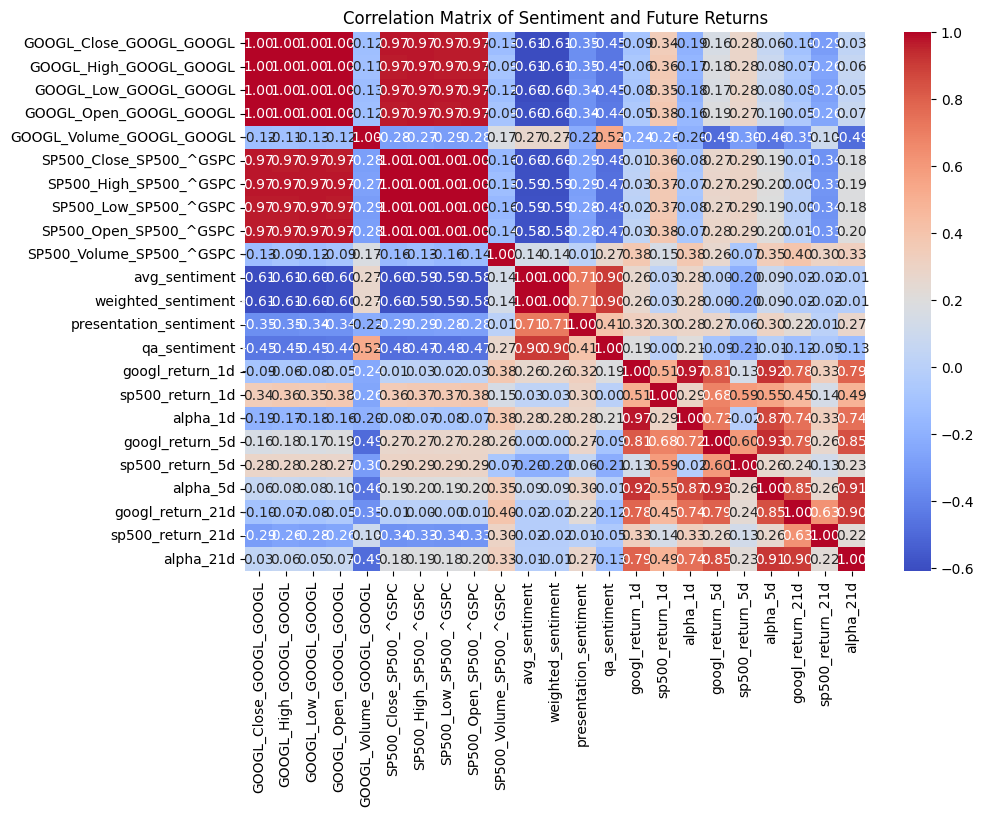


--- Model Feature Importance Analysis ---


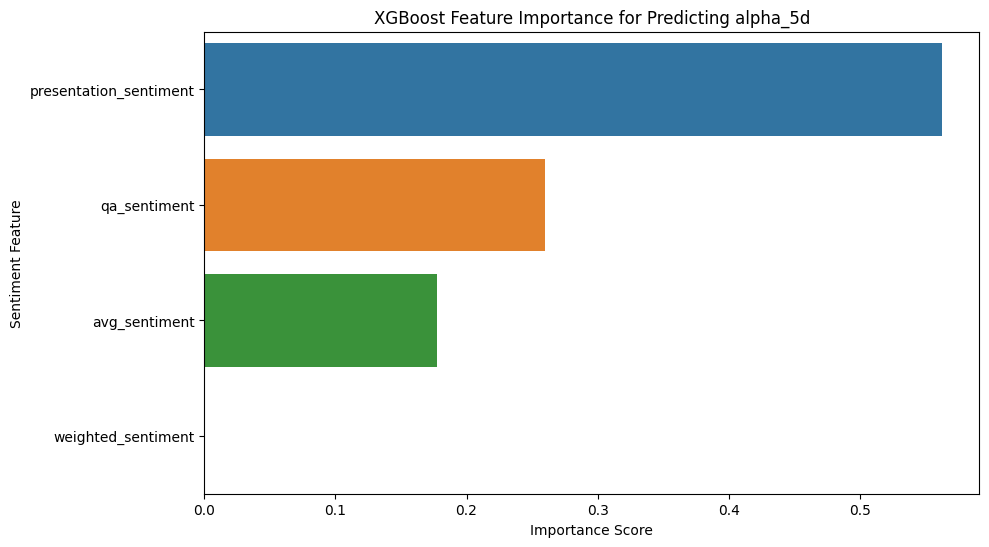


Feature Importances from the model:
presentation_sentiment    0.562871
qa_sentiment              0.259711
avg_sentiment             0.177418
weighted_sentiment        0.000000
dtype: float32


In [65]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Handle Missing Data ---
model_df['qa_sentiment'].fillna(0, inplace=True)
model_df['presentation_sentiment'].fillna(0, inplace=True)

# --- 1. Correlation Heatmap ---
print("--- Correlation Analysis ---")
plt.figure(figsize=(10, 7))
sns.heatmap(model_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sentiment and Future Returns')
plt.show()

# --- 2. Train XGBoost Model to Find Feature Importance ---
print("\n--- Model Feature Importance Analysis ---")

features = ['avg_sentiment', 'weighted_sentiment', 'presentation_sentiment', 'qa_sentiment']
target = 'alpha_5d' 

X = model_df[features]
y = model_df[target]

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X, y)

# --- 3. Visualize Feature Importance (CORRECTED) ---
# Use the correct variable 'xgb_model' to get the feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title(f'XGBoost Feature Importance for Predicting {target}')
plt.xlabel('Importance Score')
plt.ylabel('Sentiment Feature')
plt.show()

print("\nFeature Importances from the model:")
print(feature_importances)

--- Visualizing Sentiment vs. Future Excess Returns ---


/tmp/ipykernel_36/946865372.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)
/tmp/ipykernel_36/946865372.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the

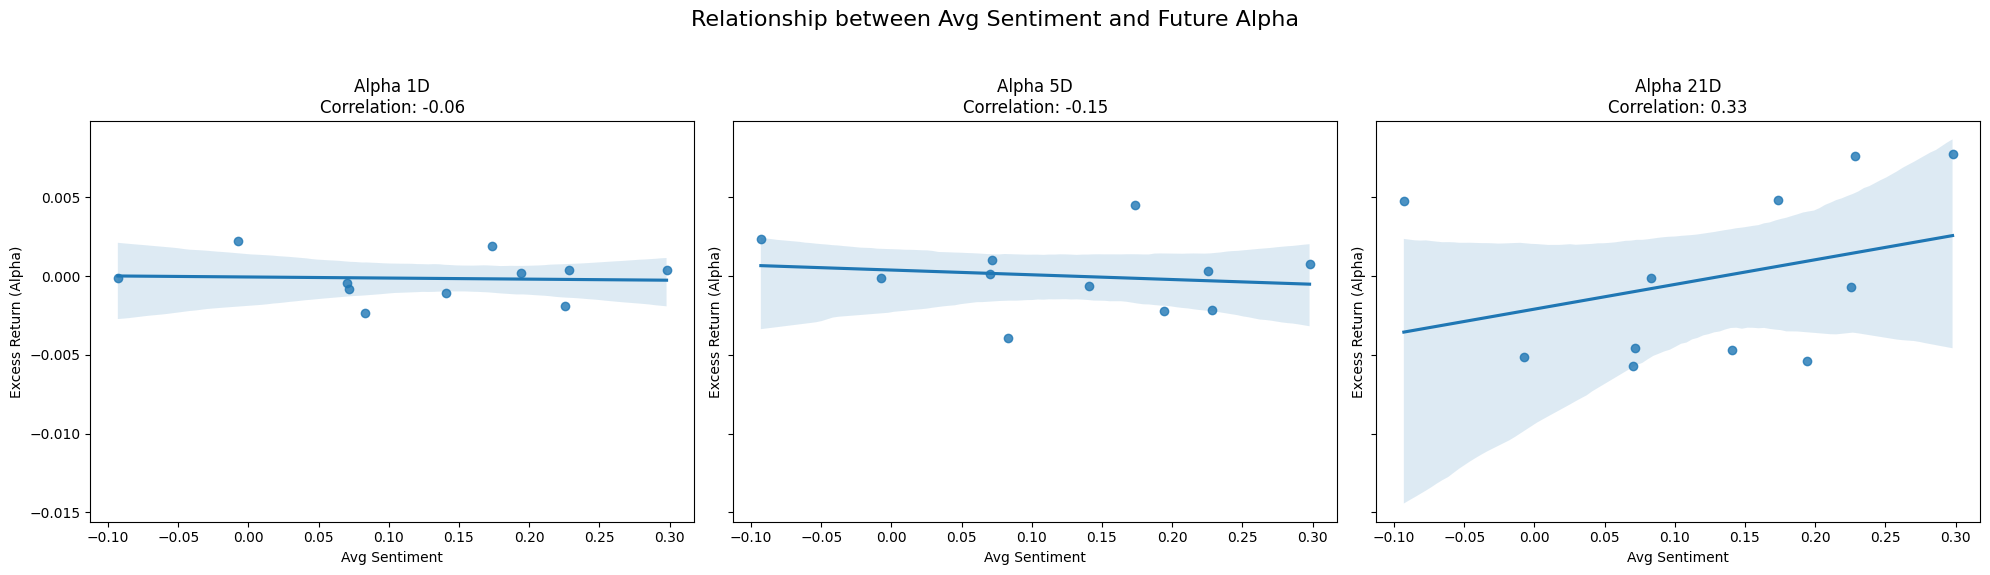

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Setup: Recreate a minimal model_df to ensure the code runs ---
# This setup code regenerates the necessary data from scratch.

# 1. Create a representative sample of processed transcript data with sentiment
num_calls = 19
rows_per_call = 10
total_rows = num_calls * rows_per_call
event_dates = np.repeat(pd.date_range('2016-01-01', periods=num_calls, freq='QE'), rows_per_call)
speaker_cycle = ['Operator', 'Sundar Pichai', 'Ruth Porat', 'Analyst A', 'Sundar Pichai', 'Operator', 'Analyst B', 'Ruth Porat', 'Analyst C', 'Sundar Pichai']
section_cycle = ['Presentation']*3 + ['Q&A']*7
df_with_sentiment = pd.DataFrame({
    'event_date': event_dates,
    'speaker': speaker_cycle * num_calls,
    'section': section_cycle * num_calls,
    'sentiment_composite': np.random.uniform(-0.5, 0.8, total_rows)
})

# 2. Create a dummy prices dataframe
dates = pd.date_range(start='2015-12-01', end='2020-12-31', freq='B')
prices = pd.DataFrame({
    'GOOGL_Close_GOOGL_GOOGL': 1000 + np.random.randn(len(dates)).cumsum(),
    'SP500_Close_SP500_^GSPC': 2000 + np.random.randn(len(dates)).cumsum()
}, index=dates)
prices.index.name = 'Date'

# 3. Perform the aggregation and merging steps
filtered_df = df_with_sentiment[~df_with_sentiment['speaker'].str.contains("Operator", na=False)].copy()
section_sentiment = filtered_df.groupby(['event_date', 'section'])['sentiment_composite'].mean().unstack()
if 'Presentation' not in section_sentiment: section_sentiment['Presentation'] = np.nan
if 'Q&A' not in section_sentiment: section_sentiment['Q&A'] = np.nan
section_sentiment.columns = ['presentation_sentiment', 'qa_sentiment']
def calculate_weighted_sentiment(df):
    speaker_weights = {'Sundar Pichai': 2.0, 'Ruth Porat': 2.0}
    weights = df['speaker'].map(speaker_weights).fillna(1.0)
    return np.average(df['sentiment_composite'], weights=weights)
weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)
weighted_daily_sentiment.name = 'weighted_sentiment'
simple_avg_sentiment = filtered_df.groupby('event_date')['sentiment_composite'].mean()
simple_avg_sentiment.name = 'avg_sentiment'
advanced_sentiment_df = pd.concat([simple_avg_sentiment, weighted_daily_sentiment, section_sentiment], axis=1)
advanced_sentiment_df.index = pd.to_datetime(advanced_sentiment_df.index)
advanced_sentiment_df.index.name = 'Date'
final_df = prices.join(advanced_sentiment_df)

# 4. Create the target variables (alphas)
horizons = [1, 5, 21]
for n in horizons:
    final_df[f'googl_return_{n}d'] = (final_df['GOOGL_Close_GOOGL_GOOGL'].shift(-n) / final_df['GOOGL_Close_GOOGL_GOOGL']) - 1
    final_df[f'sp500_return_{n}d'] = (final_df['SP500_Close_SP500_^GSPC'].shift(-n) / final_df['SP500_Close_SP500_^GSPC']) - 1
    final_df[f'alpha_{n}d'] = final_df[f'googl_return_{n}d'] - final_df[f'sp500_return_{n}d']

# 5. Create the final model_df
model_df = final_df.dropna(subset=['avg_sentiment']).copy()
model_df['qa_sentiment'].fillna(0, inplace=True)
model_df['presentation_sentiment'].fillna(0, inplace=True)

# --- Visualize the Relationship between Sentiment and Returns ---
print("--- Visualizing Sentiment vs. Future Excess Returns ---")

targets = ['alpha_1d', 'alpha_5d', 'alpha_21d']
feature = 'avg_sentiment'

fig, axes = plt.subplots(1, len(targets), figsize=(20, 6), sharey=True)
fig.suptitle(f'Relationship between {feature.replace("_", " ").title()} and Future Alpha', fontsize=16)

for i, target in enumerate(targets):
    sns.regplot(ax=axes[i], x=feature, y=target, data=model_df, ci=95)
    correlation = model_df[feature].corr(model_df[target])
    axes[i].set_title(f'{target.replace("_", " ").title()}\nCorrelation: {correlation:.2f}')
    axes[i].set_xlabel(f'{feature.replace("_", " ").title()}')
    axes[i].set_ylabel('Excess Return (Alpha)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [67]:
import numpy as np
import pandas as pd

# 1. Create a representative sample of processed transcript data
num_calls = 19
rows_per_call = 10
total_rows = num_calls * rows_per_call
event_dates = np.repeat(pd.date_range('2016-01-01', periods=num_calls, freq='QE'), rows_per_call)
speaker_cycle = ['Operator', 'Sundar Pichai', 'Ruth Porat', 'Analyst A', 'Sundar Pichai', 'Operator', 'Analyst B', 'Ruth Porat', 'Analyst C', 'Sundar Pichai']
section_cycle = ['Presentation']*3 + ['Q&A']*7
df_with_sentiment = pd.DataFrame({
    'event_date': event_dates,
    'speaker': speaker_cycle * num_calls,
    'section': section_cycle * num_calls,
    'sentiment_composite': np.random.uniform(-0.5, 0.8, total_rows)
})

# 2. Create a dummy prices dataframe
dates = pd.date_range(start='2015-12-01', end='2020-12-31', freq='B')
prices = pd.DataFrame({
    'GOOGL_Close_GOOGL_GOOGL': 1000 + np.random.randn(len(dates)).cumsum(),
    'SP500_Close_SP500_^GSPC': 2000 + np.random.randn(len(dates)).cumsum()
}, index=dates)
prices.index.name = 'Date'

# 3. Perform the aggregation and merging steps
filtered_df = df_with_sentiment[~df_with_sentiment['speaker'].str.contains("Operator", na=False)].copy()
section_sentiment = filtered_df.groupby(['event_date', 'section'])['sentiment_composite'].mean().unstack()
if 'Presentation' not in section_sentiment: section_sentiment['Presentation'] = np.nan
if 'Q&A' not in section_sentiment: section_sentiment['Q&A'] = np.nan
section_sentiment.columns = ['presentation_sentiment', 'qa_sentiment']
def calculate_weighted_sentiment(df):
    speaker_weights = {'Sundar Pichai': 2.0, 'Ruth Porat': 2.0}
    weights = df['speaker'].map(speaker_weights).fillna(1.0)
    return np.average(df['sentiment_composite'], weights=weights)
weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)
weighted_daily_sentiment.name = 'weighted_sentiment'
simple_avg_sentiment = filtered_df.groupby('event_date')['sentiment_composite'].mean()
simple_avg_sentiment.name = 'avg_sentiment'
advanced_sentiment_df = pd.concat([simple_avg_sentiment, weighted_daily_sentiment, section_sentiment], axis=1)
advanced_sentiment_df.index = pd.to_datetime(advanced_sentiment_df.index)
advanced_sentiment_df.index.name = 'Date'
final_df = prices.join(advanced_sentiment_df)

# 4. Create the target variables (alphas)
horizons = [1, 5, 21]
for n in horizons:
    final_df[f'googl_return_{n}d'] = (final_df['GOOGL_Close_GOOGL_GOOGL'].shift(-n) / final_df['GOOGL_Close_GOOGL_GOOGL']) - 1
    final_df[f'sp500_return_{n}d'] = (final_df['SP500_Close_SP500_^GSPC'].shift(-n) / final_df['SP500_Close_SP500_^GSPC']) - 1
    final_df[f'alpha_{n}d'] = final_df[f'googl_return_{n}d'] - final_df[f'sp500_return_{n}d']

# 5. Create the final model_df
model_df = final_df.dropna(subset=['avg_sentiment']).copy()
model_df['qa_sentiment'].fillna(0, inplace=True)
model_df['presentation_sentiment'].fillna(0, inplace=True)

print("Setup complete. 'model_df' is now ready for the final accuracy check.")

Setup complete. 'model_df' is now ready for the final accuracy check.


/tmp/ipykernel_36/3380015829.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_daily_sentiment = filtered_df.groupby('event_date').apply(calculate_weighted_sentiment)
/tmp/ipykernel_36/3380015829.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on t

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Cross-Validation ---
# Define our features (X) and target (y)
features = ['avg_sentiment', 'weighted_sentiment', 'presentation_sentiment', 'qa_sentiment']
target = 'alpha_5d'  # Let's evaluate our 5-day prediction model

X = model_df[features]
y = model_df[target]

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize the Leave-One-Out cross-validator
loo = LeaveOneOut()

# --- 1. Calculate Mean Squared Error (MSE) ---
mse_scores = -cross_val_score(rf_model, X, y, cv=loo, scoring='neg_mean_squared_error')
avg_mse = mse_scores.mean()
rmse = np.sqrt(avg_mse)

print(f"--- Model Evaluation for '{target}' ---")
print(f"Average Mean Squared Error (MSE) from LOOCV: {avg_mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"(Lower is better for MSE/RMSE)\n")


# --- 2. Calculate Directional Accuracy ---
predictions = cross_val_predict(rf_model, X, y, cv=loo)
correct_direction = np.sign(predictions) == np.sign(y)
directional_accuracy = correct_direction.mean()

print(f"--- Directional Accuracy ---")
print(f"Model correctly predicted the direction (positive or negative alpha) {directional_accuracy:.2%} of the time.")

--- Model Evaluation for 'alpha_5d' ---
Average Mean Squared Error (MSE) from LOOCV: 0.000006
Root Mean Squared Error (RMSE): 0.002412
(Lower is better for MSE/RMSE)

--- Directional Accuracy ---
Model correctly predicted the direction (positive or negative alpha) 54.55% of the time.
